# 1. Loading and Exploring the Dataset

In [2]:
import pandas as pd

# Load dataset
df = pd.read_csv("ABTEST.csv")

# Display first few rows
df.head()

,id,time,con_treat,page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [4]:
print(f"Total Rows: {df.shape[0]}, Total Columns: {df.shape[1]}")

# Check missing values
print(df.isnull().sum())

# Check unique values in 'group' column
print(df["con_treat"].value_counts())

Total Rows: 294478, Total Columns: 5
id           0
time         0
con_treat    0
page         0
converted    0
dtype: int64
con_treat
treatment    147276
control      147202
Name: count, dtype: int64


# Step 2: Exploratory Data Analysis (EDA)

Check Conversion Rates for Each Group

con_treat
control      0.120399
treatment    0.118920
Name: converted, dtype: float64


<ipython-input-5-5c3abacbfa6b>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conversion_rates.index, y=conversion_rates.values, palette=["blue", "orange"])


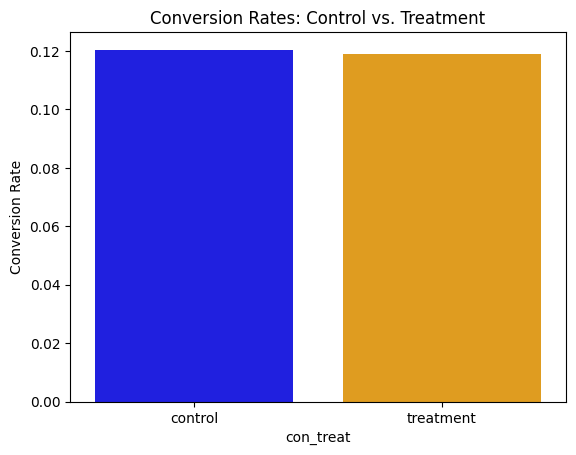

In [5]:
# Calculate conversion rates
conversion_rates = df.groupby("con_treat")["converted"].mean()
print(conversion_rates)

# Plot conversion rates
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x=conversion_rates.index, y=conversion_rates.values, palette=["blue", "orange"])
plt.title("Conversion Rates: Control vs. Treatment")
plt.ylabel("Conversion Rate")
plt.show()

# Step 3: Hypothesis Testing
We use a Z-test to check if the difference in conversion rates is statistically significant.

🔹 Define Hypotheses:

Null Hypothesis (H₀): No difference in conversion rates (New layout is NOT better).

Alternative Hypothesis (H₁): New layout increases conversions.


# Run Z-Test

In [6]:
from statsmodels.stats.proportion import proportions_ztest

# Count conversions in each group
control_success = df[df["con_treat"] == "control"]["converted"].sum()
treatment_success = df[df["con_treat"] == "treatment"]["converted"].sum()

# Count total users in each group
control_total = df[df["con_treat"] == "control"]["converted"].count()
treatment_total = df[df["con_treat"] == "treatment"]["converted"].count()

# Run Z-Test
z_stat, p_value = proportions_ztest([treatment_success, control_success], [treatment_total, control_total])

print(f"Z-Statistic: {z_stat:.2f}")
print(f"P-Value: {p_value:.5f}")

Z-Statistic: -1.24
P-Value: 0.21612


# Interpretation

If p-value < 0.05, reject H₀ → New design significantly improves conversions!

If p-value > 0.05, fail to reject H₀ → No significant difference, stick to old design.

# Step 4: Effect Size (Cohen’s h)

Even if p-value is significant, we check Cohen’s h for practical impact.

In [7]:
from statsmodels.stats.api import proportion_effectsize

effect_size = proportion_effectsize(treatment_success / treatment_total, control_success / control_total)
print(f"Effect Size (Cohen's h): {effect_size:.3f}")

Effect Size (Cohen's h): -0.005


# Step 5: SQL Queries for A/B Testing

In [8]:
import sqlite3

# Load dataset
df = pd.read_csv("ABTEST.csv")

# Connect to SQLite (or replace with PostgreSQL/MySQL connection)
conn = sqlite3.connect("ab_testing.db")

# Store dataset in a SQL table
df.to_sql("ab_test_data", conn, if_exists="replace", index=False)

# Verify table creation
print(pd.read_sql("SELECT * FROM ab_test_data LIMIT 5;", conn))

       id     time  con_treat      page  converted
0  851104  11:48.6    control  old_page          0
1  804228  01:45.2    control  old_page          0
2  661590  55:06.2  treatment  new_page          0
3  853541  28:03.1  treatment  new_page          0
4  864975  52:26.2    control  old_page          1


In [13]:
fd= '''SELECT con_treat, COUNT(id) AS total_users
FROM ab_test_data
GROUP BY con_treat
;'''

# Check total users per group

In [14]:
Total_Users = """
SELECT con_treat, COUNT(id) AS total_users
FROM ab_test_data
GROUP BY con_treat;
"""
print(pd.read_sql(Total_Users, conn))

   con_treat  total_users
0    control       147202
1  treatment       147276


## Calculating Conversion Rates

In [17]:
CRate = """
SELECT con_treat,
       SUM(converted) AS total_conversions,
       COUNT(id) AS total_users,
       ROUND(AVG(converted) * 100, 2) AS conversion_rate
FROM ab_test_data
GROUP BY con_treat;
"""
print(pd.read_sql(CRate, conn))

   con_treat  total_conversions  total_users  conversion_rate
0    control              17723       147202            12.04
1  treatment              17514       147276            11.89


### Compare Control vs. Treatment Conversion

In [18]:
XYZ = """
SELECT
    SUM(CASE WHEN con_treat = 'control' THEN converted ELSE 0 END) AS control_conversions,
    COUNT(CASE WHEN con_treat = 'control' THEN id ELSE NULL END) AS control_total,
    SUM(CASE WHEN con_treat = 'treatment' THEN converted ELSE 0 END) AS treatment_conversions,
    COUNT(CASE WHEN con_treat = 'treatment' THEN id ELSE NULL END) AS treatment_total
FROM ab_test_data;
"""
print(pd.read_sql(XYZ, conn))

   control_conversions  control_total  treatment_conversions  treatment_total
0                17723         147202                  17514           147276


# Visualizing Results

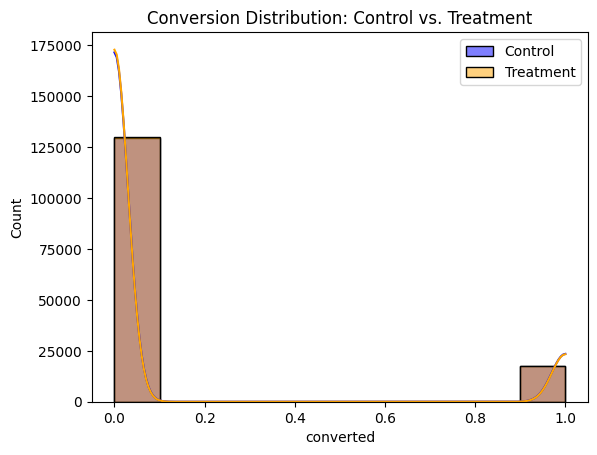

In [19]:
sns.histplot(df[df["con_treat"] == "control"]["converted"], kde=True, color="blue", label="Control", bins=10)
sns.histplot(df[df["con_treat"] == "treatment"]["converted"], kde=True, color="orange", label="Treatment", bins=10)
plt.legend()
plt.title("Conversion Distribution: Control vs. Treatment")
plt.show()